# Introduction to Imbalanced Classes

Most of the datasets covered in machine learning courses are *balanced*. This is because you are learning how the algorithm works without worrying about additional information unrelated to the learning objective. When you start working with real, uncleaned data one of the first things you notice is how much noisier and imbalanced it is.

This lesson is meant to provide an overview of the different methods available for handling imbalanced classes, the differences between oversmapling techniques, and avoiding the "metric trap".


Some examples of imbalanced classes:

* Fraud detection
* Medical screening
* Detecting defects in a factory
* Ad conversation rates

In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# packages needed for this notebook: MLXTEND, IMBALANCED-LEARN
#!pip install mlxtend
#!conda install -c conda-forge imbalanced-learn -y

In [3]:
# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

In [4]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# The Metric Trap

![](images/itsatrap.jpg)

The "Metric Trap" is a result of training for accuracy (as most models in sklearn are wont to do). If the dataset has 1% of the data in class 1, we can predict class 0 **all the time** and get an accuracy of 99%!

You need to unzip the train.7z file in the repo for this line to work. Uncomment line below to unzip file.  
You may need to install 7zip first by running the following in the command line:  
```
brew update   
brew install p7zip```

In [8]:
#!7z x data/train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,4 CPUs x64)

Scanning the drive for archives:
  0M Sca        1 file, 17022819 bytes (17 MiB)

Extracting archive: data/train.7z
--
Path = data/train.7z
Type = 7z
Physical Size = 17022819
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

     10% - train.c               28% - train.c               47% - train.c               65% - train.c               83% - train.c              100%    Everything is Ok

Size:       115852544
Compressed: 17022819


In [9]:
imbalanced_df = pd.read_csv('train.csv')
target_count = imbalanced_df.target.value_counts()

In [10]:
# remove dataset to avoid accidental Git submissions
!rm train.csv

In [11]:
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1
Percentage of Majority Class: 96.36


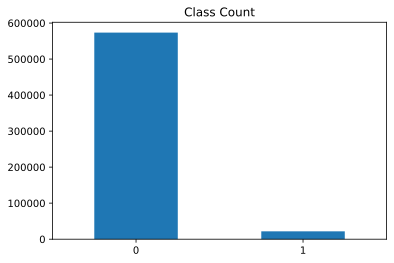

In [12]:
target_count.plot(kind='bar', title='Class Count', rot=0);

**What can potentially happen when we build a classifier on an imbalanced dataset?**

**Ans:** Worst case scenario, we predict the majority class all the time. In other times, the algorithm reaches a suboptimal decision and model performance suffers.

In [13]:
X = imbalanced_df.iloc[:, 2:]
y = imbalanced_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [ ]:
# We'll go straight to a robust classifier to show even they are prone to the metric trap
# takes ~ 1 min to run
clf = XGBClassifier().fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {round(accuracy, 4)*100}')

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

Even though we used a robust classifier, our model is essentially only predicting one class regardless of the underlying data! 

Let's look at different methods for handling imbalanced class datasets

# Method 1 - Oversampling

![](images/Oversampling.png)

Oversampling does what its name implies. Takes the minority class and over-samples it until it is balanced with the majority class.

In [ ]:
# Generate synthetic imbalanced data 
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1, 
                           weights=[0.04, 0.96],
                           class_sep=0.2, random_state=42)

In [ ]:
df = pd.DataFrame(X, columns=['column1', 'column2'])
df['label'] = y

In [ ]:
sns.lmplot('column1', 'column2', data=df, hue='label',
           palette='Set2', fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(12,8);


In [ ]:
# Build a classifier on this data set and plot the decision region
clf = SVC().fit(X, y)
plot_decision_regions(X, y, clf)
plt.title(f'SVC with y = {Counter(y)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf.predict(X)), ['Class 0', 'Class 1'])

The confusion matrix and decision region plot above show that we are still getting the minority class wrong whenever a minority sample is close to the region where the bulk of the majority points lie.

### Can we do better? 
Yes! By oversampling the minority class.

In [ ]:
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [ ]:
# Yay, balanced classes!
Counter(y_resampled)

In [ ]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
clf_ros = SVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_ros)
plt.title(f'Oversampled SVC with y = {Counter(y_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf_ros.predict(X)), ['Class 0', 'Class 1'])

**Much better!** - just by using random oversampling, we were able to classify correctly an additional 30 minority points. Remember, this is the class we are interested in classifying correctly.

## SMOTE - Synthetic Minority Oversampling TEchnique

![](images/smote.png)

In [ ]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

In [ ]:
Counter(y_smoted)

In [ ]:
# Build classifier and plot decision region with SMOTE data
clf_smote = SVC().fit(X_smoted, y_smoted)
plot_decision_regions(X_smoted, y_smoted, clf_smote)
plt.title(f'SMOTE SVC with y = {Counter(y_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf_smote.predict(X)), ['Class 0', 'Class 1'])

Although we used a different technique, we achieved the same result as random oversampling. 


**Can you explain why that was the case?**


**Ans:** SMOTE does not differentiate between points near the decision boundary and points far away from it. Thus, it generated new points in areas that did not matter for the classifier.

## Student Exercise

Another method we can try is ADASYN (ADAptive SYNthetic oversampling). Instead of generating synthetic observations between any minority points, it puts more emphasis on the regions where the class imbalance is greatest. In other words, in the regions where the classifier is most likely to predict the majority class.

In [ ]:
# Import ADASYN and create a new oversampled dataset

## Code goes here ##
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

In [ ]:
# Check that our dataset is reasonably balanced

## Code goes here ##
Counter(y_adasyn)

In [ ]:
# Create SVC classifier using the data and plot the decision region

## Code goes here ##
clf_adasyn = SVC().fit(X_adasyn, y_adasyn)
plot_decision_regions(X_adasyn, y_adasyn, clf_adasyn)
plt.title(f'ADASYN SVC with y = {Counter(y_adasyn)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
# print confusion matrix

## Code goes here ##
cm = print_confusion_matrix(confusion_matrix(y, clf_adasyn.predict(X)), ['Class 0', 'Class 1'])

### Reasoning Check
In your opinion, which oversampling method worked best for **this** dataset? Why? 

**Ans:** This depends. Clearly, the model with ADASYN does better at classifying the minority class, but it also comes at the cost of misclassifying 879 observations from the majority class. If you're building a fraud detector, this might be acceptable! If detecting some unwanted medical disease, a lot of patients will have increased medical fees related to additional testing, prescription drugs, etc., which is not a good outcome. Understand the business reason and the costs associated with false positives/negatives to determine what is an acceptable trade-off.

# Method 2 - Undersampling

![](images/undersampling.png)

Undersampling is the opposite of Oversampling. It takes the majority class and under-samples it until it is balanced with the minority class.

**In what scenarios would this method be useful?**

**Ans:** If your model is computationally expensive and doubling the size of the data would hurt performance, undersampling would be a better approach.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,y)

In [ ]:
Counter(y_under)

In [ ]:
clf_rus = SVC().fit(X_under, y_under)
plot_decision_regions(X_under, y_under, clf_rus)
plt.title(f'Undersampled SVC with y = {Counter(y_under)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf_rus.predict(X)), ['Class 0', 'Class 1'])

Random undersampling can be a valid method to try, especially if you have large datasets and want to avoid increasing computation time. In our case, we didn't do much better by undersampling though the imbalanced learn library (`imblearn`) has additional tools/methods for undersampling.

# Multiclass Classification

Let's look at what happens when there are multiple classes, one of which is highly imbalanced. Fortunately, the methods we covered for binary classification still work in a multiclass setting.

In [ ]:
# Generate synthetic imbalanced multiclass data
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1, 
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

In [ ]:
df = pd.DataFrame(X, columns=['column1', 'column2'])
df['label'] = y

In [ ]:
sns.lmplot('column1', 'column2', data=df, hue='label',
           palette='Set1', fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(12,8)

In [ ]:
# Let's see how this performs using a linear SVC
clf = LinearSVC().fit(X, y)
plot_decision_regions(X, y, clf)
plt.title(f' Linear SVC with y = {Counter(y)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf.predict(X)), ['Class 0', 'Class 1', 'Class 2'])

Our linear SVC is still having problems with class 0 and class 1, though the effects are more drastic for class 1. 

How about if our model was predicting the likelihood of having a rare, but aggressive, form of cancer? Would we still be okay misclassifying ~80% of these cases?

In [ ]:
# Now let's add some random oversampling of the minority classes
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [ ]:
# check our classes are balanced
Counter(y_resampled)

In [ ]:
clf_ros = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_ros)
plt.title(f' Oversampled Linear SVC with y = {Counter(y_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf_ros.predict(X)), ['Class 0', 'Class 1', 'Class 2'])

In [ ]:
# ADASYN worked well before, how about now? 
X_adasyn, y_adasyn = ADASYN().fit_sample(X,y)

In [ ]:
clf_smote = LinearSVC().fit(X_adasyn, y_adasyn)
plot_decision_regions(X_smoted, y_smoted, clf_smote)
plt.title(f'ADASYN SVC with y = {Counter(y_adasyn)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y, clf_smote.predict(X)), ['Class 0', 'Class 1', 'Class 2'])

# Logical workflow for handling imbalanced classes

The following list is helpful when dealing with imbalanced datasets.

### Do Nothing!
That's right, sometimes we'll get lucky and our classifier will deal effectively with the class imbalance. Go celebrate.

### Balance the dataset in some way
- Would you run into _serious_ computational issues by doubling the amount of data you have? If so, use **Random Undersampling**
- If you have a lot variety in your dataset, you can try **Random Oversampling** as this method will generalize well from the minority observations you currently have.
- If Random Oversampling didn't work as well as you had hoped, try **generating synthetic data** with SMOTE or ADASYN. 


### Switch to an Anomaly Detection Algorithm
If the above experiments don't yield the desired results, switch to an anomaly detection algorithm (not covered in this notebook).

# Recap

In this lesson we focused on tools used to tackle imbalanced datasets. They have applications in many areas in data science since most real world data is naturally imbalanced.  


Things to note:

- The metric trap is real, even "Kaggle-winning algorithms" are prone to failure with highly imbalanced datasets. 
- Which method we use will be dependent on the problem. For example, sometimes ADAYSN will work great, in other cases, not so much. 
- If the dataset is small to begin with, undersampling may reduce your data too much and many classifiers will have difficulty generalizing.
- Oversampling methods may prove to be computationally intensive depending which algorithm is being used. Find out what limitations you have an adjust accordingly.
- Always think of the business case! Is misclassifying the majority class just as bad as misclassifying the minority class? What is the right metric for your model?